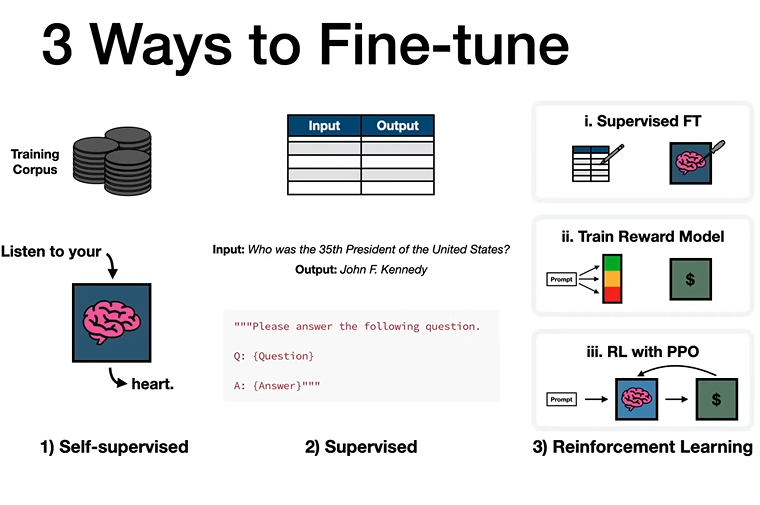

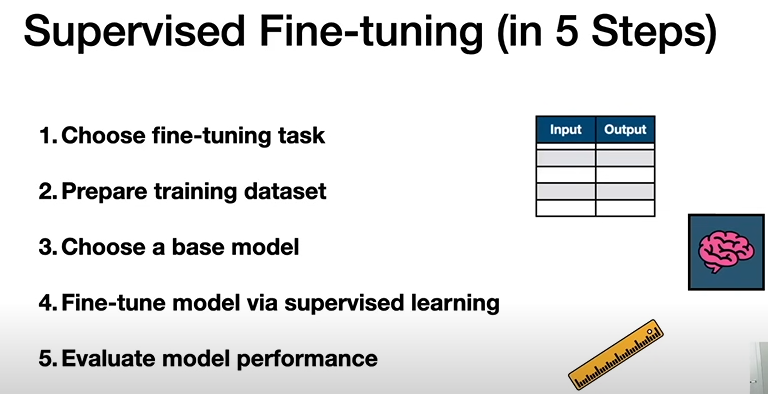

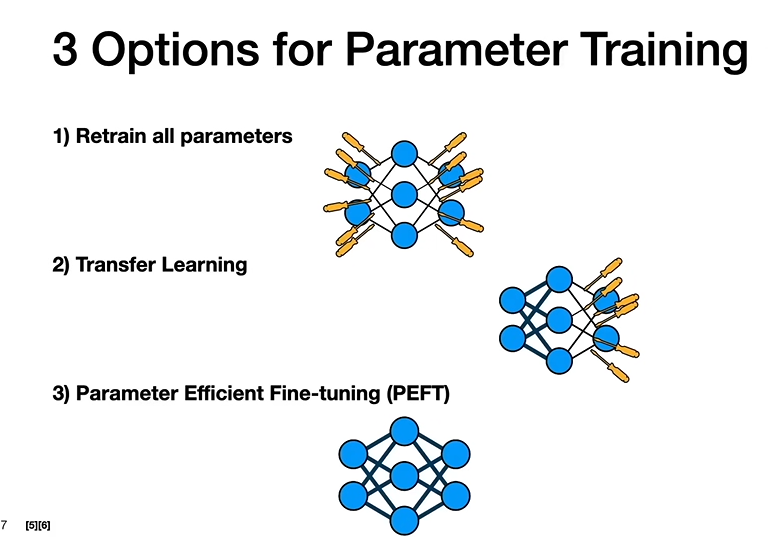

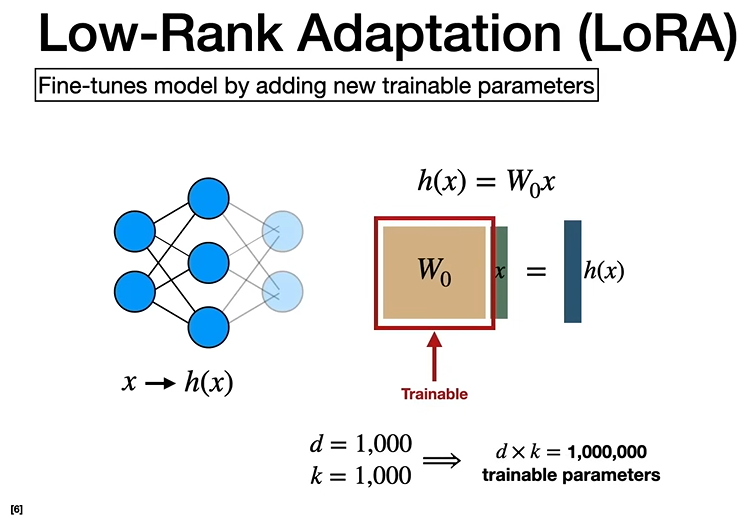

# Example 1

## Custom_Sentiment_Analysis
### DistilBERT, short for "Distilled BERT," is a smaller and faster version of the BERT (Bidirectional Encoder Representations from Transformers) model.
### DistilBERT, a compressed version of BERT, employs a 6-layer Transformer architecture with 768 hidden units, reducing computational complexity while maintaining competitive performance. Utilizing knowledge distillation, it emulates the behavior of BERT, achieving faster inference times and reduced resource requirements. Pre-trained DistilBERT models are available for various languages and tasks, enabling fine-tuning on specific datasets for tasks like text classification and sentiment analysis. Despite its smaller size, DistilBERT offers an efficient solution for natural language processing applications, delivering a balance between model size, speed, and performance in resource-constrained environments.

In [16]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('SMSSpamCollection.txt', sep='\t', names=["label", "message"])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

X = list(df['message'])
y = list(df['label'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Define and load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the training and testing data
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

# Create TensorFlow datasets from tokenized data
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

# Define training arguments
training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_steps=100                   # evaluation steps, set it to an appropriate value
)

# Instantiate the model within the training scope
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Initialize the trainer
trainer = TFTrainer(
    model=model,                    # the instantiated 🤗 Transformers model to be trained
    args=training_args,             # training arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=test_dataset       # evaluation dataset
)

# Train the model
trainer.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, predicted_labels)

# Display classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[954   1]
 [  4 156]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       955
           1       0.99      0.97      0.98       160

    accuracy                           1.00      1115
   macro avg       0.99      0.99      0.99      1115
weighted avg       1.00      1.00      1.00      1115



In [18]:
# Save the trained model
model.save_pretrained("saved_model")

# Load the saved model
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("saved_model")

Some layers from the model checkpoint at saved_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_291']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model and are newly initialized: ['dropout_311']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Define a function for making predictions on new text
def predict_text(text):
    # Tokenize the text
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="tf")
    
    # Make prediction
    logits = loaded_model(inputs)[0]
    
    # Get predicted label
    predicted_label = np.argmax(logits, axis=1).squeeze()
    
    return predicted_label

# Example usage
new_text = "REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode"
predicted_label = predict_text(new_text)
print("Predicted label:", predicted_label)

Predicted label: 1


In [20]:
#https://github.com/justmarkham/DAT5/blob/master/data/SMSSpamCollection.txt
#https://huggingface.co/docs/transformers/training

# EXAMPLE 2

In [8]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
import pandas as pd
import random

# Define the text samples and corresponding sentiment labels
texts = [
    "I love this product, it's amazing!",
    "The service was terrible, I'm very disappointed.",
    "This movie is just okay, nothing special.",
    "I had a neutral experience with the company.",
    "The food at the restaurant was excellent.",
    "I don't recommend this book, it's boring.",
    "The hotel room was clean and comfortable.",
    "The customer support team was helpful.",
    "The weather today is neither good nor bad.",
    "I'm satisfied with the performance of the device.",
    "The experience was unpleasant, I won't go back.",
    "The new feature is fantastic, I'm impressed.",
    "The traffic was awful, it took forever to get home.",
    "The product quality is subpar, I expected better.",
    "The atmosphere of the place was relaxing.",
    "The delivery was delayed, very frustrating.",
    "The staff was friendly and welcoming.",
    "I'm indifferent towards this product.",
    "The concert was amazing, I had a great time.",
    "The user interface is user-friendly and intuitive.",
    "The price is too high for the value provided.",
    "The event was cancelled, what a disappointment.",
    "The movie plot was predictable, not worth watching.",
    "I'm ambivalent about this issue.",
    "The game performance was flawless.",
    "The experience left me feeling unsatisfied.",
    "I highly recommend this service!",
    "The customer experience needs improvement.",
    "The coffee tasted awful, I couldn't finish it.",
    "The software is buggy, needs fixing.",
    "The meeting was unproductive, a waste of time.",
    "I have mixed feelings about this decision.",
    "The presentation was engaging and informative.",
    "The product exceeded my expectations.",
    "The feedback received was constructive.",
    "The support staff was unhelpful and rude.",
    "The hotel amenities were lacking.",
    "I'm content with the outcome.",
    "The performance of the device was disappointing.",
    "The service quality has deteriorated over time.",
    "The delivery person was rude and unprofessional.",
    "The movie was a masterpiece, I enjoyed every minute of it.",
    "The website navigation is confusing, needs improvement.",
    "The customer service agent was polite and efficient.",
    "The software update fixed many issues, it's much better now.",
    "The traffic was light today, I reached my destination quickly.",
    "The restaurant ambiance was cozy and inviting.",
    "I'm on the fence about recommending this product.",
    "The concert venue had great acoustics, the music sounded amazing."
]

# Assign labels to each sample and convert to numerical values
sentiment_map = {'positive': 2, 'negative': 0, 'neutral': 1}
labels = [sentiment_map[random.choice(['positive', 'negative', 'neutral'])] for _ in range(len(texts))]

# Create a DataFrame from the data
data = {'text': texts, 'sentiment': labels}
df = pd.DataFrame(data)

print(df.shape)
df.head()

(49, 2)


,text,sentiment
0,"I love this product, it's amazing!",1
1,"The service was terrible, I'm very disappointed.",1
2,"This movie is just okay, nothing special.",2
3,I had a neutral experience with the company.,2
4,The food at the restaurant was excellent.,0


In [13]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.20, random_state=0)

In [15]:
# Define and load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the training and testing data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Create TensorFlow datasets from tokenized data
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

# Define training arguments
training_args = TFTrainingArguments(
    output_dir='./results_sentiment',    # output directory
    num_train_epochs=3,                   # total number of training epochs
    per_device_train_batch_size=8,        # batch size per device during training
    per_device_eval_batch_size=16,        # batch size for evaluation
    warmup_steps=500,                     # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                    # strength of weight decay
    logging_dir='./logs_sentiment',       # directory for storing logs
    logging_steps=10,
    eval_steps=100                        # evaluation steps, set it to an appropriate value
)

# Instantiate the model within the training scope
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Initialize the trainer
trainer = TFTrainer(
    model=model,                    # the instantiated 🤗 Transformers model to be trained
    args=training_args,             # training arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=test_dataset       # evaluation dataset
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate(test_dataset)
print("Evaluation Results:", results)

# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = tf.argmax(predictions.predictions, axis=1).numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, predicted_labels)

# Display classification report
print("\nClassification Report:")
print(class_report)

# Save the trained model
model.save_pretrained("saved_model_sentiment")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Evaluation Results: {'eval_loss': 1.1175997257232666}
Confusion Matrix:
[[0 0 4]
 [0 0 4]
 [0 0 2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.20      1.00      0.33         2

    accuracy                           0.20        10
   macro avg       0.07      0.33      0.11        10
weighted avg       0.04      0.20      0.07        10



C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [16]:
# Load the saved model
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("saved_model_sentiment")

# Define a function for making predictions on new text
def predict_text(text):
    # Tokenize the text
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="tf")
    
    # Make prediction
    logits = loaded_model(inputs)[0]
    
    # Get predicted label
    predicted_label = tf.argmax(logits, axis=1).numpy().squeeze()
    
    return predicted_label

# Example usage
new_text = "This restaurant provides excellent service."
predicted_label = predict_text(new_text)
print("Predicted label:", predicted_label)

Some layers from the model checkpoint at saved_model_sentiment were not used when initializing TFDistilBertForSequenceClassification: ['dropout_119']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_sentiment and are newly initialized: ['dropout_139']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: 2


# EXAMPLE 3

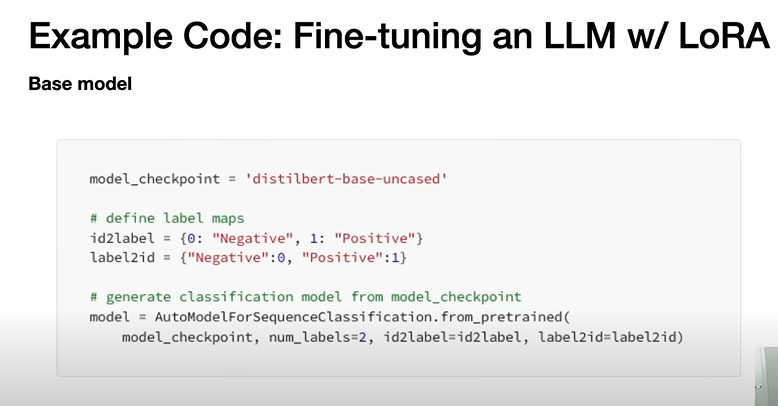

In [6]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

In [ ]:
# # how dataset was generated

# # load imdb data
# imdb_dataset = load_dataset("imdb")

# # define subsample size
# N = 1000 
# # generate indexes for random subsample
# rand_idx = np.random.randint(24999, size=N) 

# # extract train and test data
# x_train = imdb_dataset['train'][rand_idx]['text']
# y_train = imdb_dataset['train'][rand_idx]['label']

# x_test = imdb_dataset['test'][rand_idx]['text']
# y_test = imdb_dataset['test'][rand_idx]['label']

# # create new dataset
# dataset = DatasetDict({'train':Dataset.from_dict({'label':y_train,'text':x_train}),
#                              'validation':Dataset.from_dict({'label':y_test,'text':x_test})})

In [7]:
# load dataset
dataset = load_dataset('shawhin/imdb-truncated')
dataset

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

In [8]:
# display % of training data with label=1
np.array(dataset['train']['label']).sum()/len(dataset['train']['label'])

0.5

In [9]:
model_checkpoint = 'distilbert-base-uncased'
# model_checkpoint = 'roberta-base' # you can alternatively use roberta-base but this model is bigger thus training will take longer

# define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative":0, "Positive":1}

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# display architecture
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [11]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

In [12]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [13]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [14]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [16]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

In [17]:
#Apply untrained model to text
# define list of examples
text_list = ["It was good.", "Not a fan, don't recommed.", "Better than the first one.", "This is not worth watching even once.", "This one is a pass."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
It was good. - Positive
Not a fan, don't recommed. - Positive
Better than the first one. - Positive
This is not worth watching even once. - Positive
This one is a pass. - Positive


In [18]:
#Train model
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [19]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [20]:

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9306847223789819


In [21]:
# hyperparameters
lr = 1e-3
batch_size = 4
num_epochs = 10

In [22]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


In [ ]:
#Generate prediction
model.to('mps') # moving to mps for Mac (can alternatively do 'cpu')

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("mps") # moving to mps for Mac (can alternatively do 'cpu')

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

In [ ]:
#Optional: push model to hub
# option 1: notebook login
#from huggingface_hub import notebook_login
#notebook_login() # ensure token gives write access

# # option 2: key login
# from huggingface_hub import login
# write_key = 'hf_' # paste token here
# login(write_key)

In [ ]:
hf_name = 'sam' # your hf username or org name
model_id = hf_name + "/" + model_checkpoint + "-lora-text-classification" # you can name the model whatever you want

In [ ]:
#model.push_to_hub(model_id) # save model

In [ ]:
#trainer.push_to_hub(model_id) # save trainer

In [ ]:
#Optional: load peft model
# how to load peft model from hub for inference
config = PeftConfig.from_pretrained(model_id)
inference_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path, num_labels=2, id2label=id2label, label2id=label2id
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(inference_model, model_id)